In [1]:

import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_targetpixelfile

In [2]:
pixelfile = search_targetpixelfile('WASP-12', mission='TESS').download(quality_bitmask='hardest')
pixelfile.mission, pixelfile.targetid, pixelfile.sector, pixelfile.camera, pixelfile.ccd

('TESS', 86396382, 20, 1, 3)

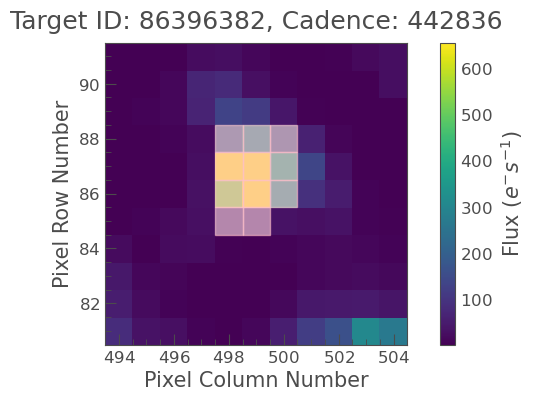

In [3]:
pixelfile.plot(frame=1, aperture_mask=pixelfile.pipeline_mask)

In [4]:
lc = pixelfile.to_lightcurve(aperture_mask=pixelfile.pipeline_mask)

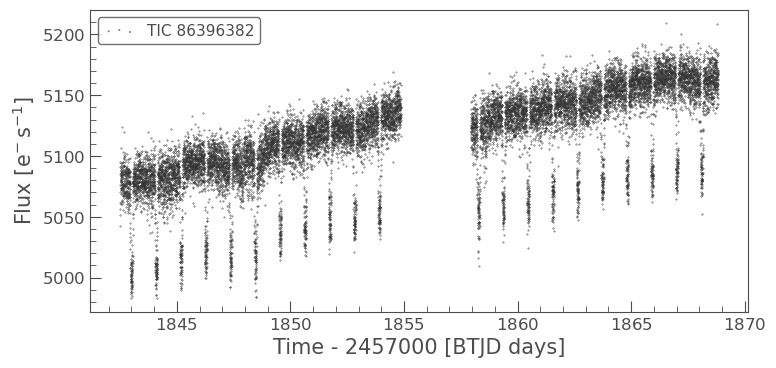

In [5]:
lc.scatter(s=0.1)

In [6]:
def phase_fold(t, per, t0):
    ph = (t-t0)/per % 1.0
    over_half = (ph >= 0.5)
    ph[over_half] = ph[over_half] - 1.0
    ep = np.round((t-t0)/per)
    return(ph, ep)

In [7]:
per = 1.091419649
tess_time_base = 2457000.000
time_ref_epoch = 2456305.455521 - tess_time_base
phase, epoch = phase_fold(lc.time, per, time_ref_epoch)

In [8]:
e1 = int(min(epoch))
e2 = int(max(epoch))
epochs_to_fit = np.arange(e1,e2+1)
npts = 0.*epochs_to_fit
print(epochs_to_fit)

[2325 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338
 2339 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349]


In [9]:
phase_trim = 0.20
for i in range(len(epochs_to_fit)):
    this_transit = ((epoch == epochs_to_fit[i]) & (np.abs(phase) <= phase_trim))
    npts[i] = np.sum(this_transit)
    
print("Range of epochs covered by time series = ", e1, e2)
print("Med, min, max, std of number of data points per transit = ",
      np.median(npts), np.min(npts), np.max(npts), np.std(npts))

Range of epochs covered by time series =  2325 2349
Med, min, max, std of number of data points per transit =  313.0 0.0 315.0 110.30648213047138


In [10]:
good = (npts >= 0.9*np.median(npts))
epochs_to_fit = epochs_to_fit[good]

In [11]:
to_fit = (np.isin(epoch, epochs_to_fit) & (np.abs(phase) <= phase_trim))
t = lc.time[to_fit]
f = lc.flux[to_fit]
ph = phase[to_fit]
e = epoch[to_fit]

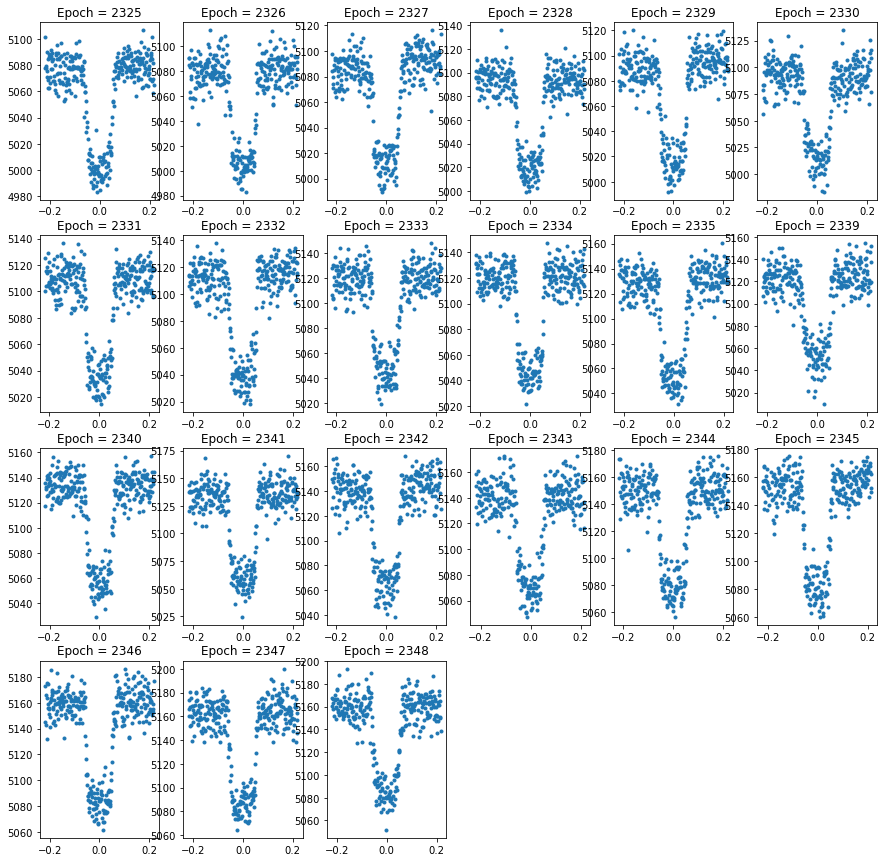

In [12]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
for i in range(len(epochs_to_fit)):
    this_transit = (e == epochs_to_fit[i])
    plt.subplot(4,6,i+1)
    plt.plot(t[this_transit]-np.mean(t[this_transit]), f[this_transit], '.')
    plt.title('Epoch = ' + str(np.int(epochs_to_fit[i])))

In [13]:
def trapezoid_transit_lc(t, f_oot, t0, depth, t14, t23):

    t_ing_start = t0 - 0.5*t14
    t_ing_end   = t_ing_start + t23
    t_egr_end   = t0 + 0.5*t14
    t_egr_start = t_egr_end - t23
    
    f_low = f_oot*(1.0-depth)
    f_calc = f_oot + 0.0*t

    full_transit = (t > t_ing_end) & (t < t_egr_start)
    f_calc[full_transit] = f_low
    
    ingress = (t >= t_ing_start) & (t <= t_ing_end)
    f_calc[ingress] = f_oot - (f_oot-f_low)*(t[ingress]-t_ing_start)/t23
    
    egress = (t >= t_egr_start) & (t <= t_egr_end)
    f_calc[egress] = f_low + (f_oot-f_low)*(t[egress]-t_egr_start)/t23
    
    return(f_calc)

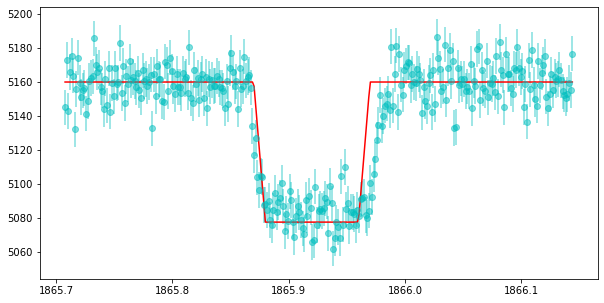

In [14]:
ph_oot = 0.10
plt.rcParams['figure.figsize'] = (10.0, 5.0)
q = (e == 2346)
t_obs = t[q]
f_obs = f[q]
ph_obs = ph[q]
oot = (np.abs(ph_obs) >= ph_oot)
f_unc = 0.0*f_obs + np.std(f_obs[oot])
plt.errorbar(t_obs,f_obs,yerr=f_unc,fmt='co',alpha=0.5)
f_calc = trapezoid_transit_lc(t_obs, 5160, 1865.92, 0.016, 0.1, 0.01)
plt.plot(t_obs,f_calc,'r')

In [15]:
def errfunc(p, t_obs, f_obs, f_unc):
    f_calc = trapezoid_transit_lc(t_obs, *p)
    return(f_obs-f_calc)

In [16]:
p0 = [5160, 1865.92, 0.016, 0.1, 0.01]

In [17]:
from scipy import optimize
out = optimize.leastsq(errfunc, p0[:], args=(t_obs, f_obs, f_unc), full_output=1)
popt = out[0]
covar = out[1]
print(popt)
punc = np.sqrt(covar.diagonal())
print(punc)

[5.16017852e+03 1.86592420e+03 1.48978179e-02 1.20121348e-01
 1.59961840e-02]
[6.62266178e-02 4.25402339e-05 2.74947325e-05 1.67308058e-04
 1.44774320e-04]


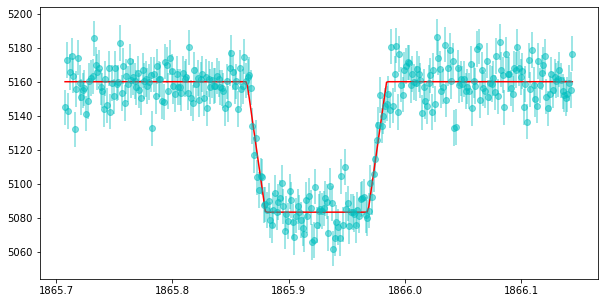

In [18]:
plt.errorbar(t_obs,f_obs,yerr=f_unc,fmt='co',alpha=0.5)
f_calc = trapezoid_transit_lc(t_obs, *popt)
plt.plot(t_obs,f_calc,'r')